In [1]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne
from pandarallel import pandarallel
import statsmodels.stats.api as sms
from brokenaxes import brokenaxes

import seaborn as sns
from scipy.stats import false_discovery_control
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

from utils import *
from connectivity_dynamics import *

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Option A: load non-verbose flow data

In [2]:
DATA_DIR = '/mnt/ernie_main/Price/ephys/data/periconnectivity'

## load one patient
# f = 'peri_ictal_flow_Epat02.csv'
# flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
# flow_df = center_onset(flow_df)

# load multiple patients
flow_df_lst = []
files = glob.glob(os.path.join(DATA_DIR,"*flow*pat*.csv"))
files = [f for f in files if ('verbose' not in f)]
for f in files:
    flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
    flow_df = center_onset(flow_df, **{'mid_sz_length':20})
    flow_df_lst.append(flow_df)
flow_df = pd.concat(flow_df_lst)

/tmp/ipykernel_192307/2995313017.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
/tmp/ipykernel_192307/2995313017.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
/tmp/ipykernel_192307/2995313017.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
/tmp/ipykernel_192307/2995313017.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
/tmp/ipykernel_192307/2995313017.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
/tmp/ipykernel_192307/2995313017.py:13: DtypeWarni

In [3]:
flow_df = flow_df[flow_df.freq_band == 'alpha']
flow_df['src_trgt'] = flow_df.parallel_apply(lambda x : x['source']+ "_"+x['target'], axis=1)
flow_df

,win_label,win_sz_st_end,sz_end,win_sz_centered,source,target,value,period,window_designations,freq_band,eventID,patID,sz_type,src_trgt
740726,interictal,-595.0,93,-595,soz,soz,0.162197,0,0.0_0.0_0.0,alpha,8,Epat03,FIAS,soz_soz
740727,interictal,-595.0,93,-595,soz,nz,0.091010,0,0.0_0.0_0.0,alpha,8,Epat03,FIAS,soz_nz
740728,interictal,-595.0,93,-595,nz,soz,0.122066,0,0.0_0.0_0.0,alpha,8,Epat03,FIAS,nz_soz
740729,interictal,-595.0,93,-595,nz,nz,0.107353,0,0.0_0.0_0.0,alpha,8,Epat03,FIAS,nz_nz
740750,interictal,-594.0,93,-594,soz,soz,0.236898,1,0.0_0.0_0.0,alpha,8,Epat03,FIAS,soz_soz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31355,post_ictal,632.0,118,711,nz,nz,0.042287,1306,2.0_2.0_2.0,alpha,1,Spat53,FBTC,nz_nz
31376,post_ictal,633.0,118,712,soz,soz,NaN,1307,2.0_2.0_2.0,alpha,1,Spat53,FBTC,soz_soz
31377,post_ictal,633.0,118,712,soz,nz,0.021688,1307,2.0_2.0_2.0,alpha,1,Spat53,FBTC,soz_nz
31378,post_ictal,633.0,118,712,nz,soz,0.032205,1307,2.0_2.0_2.0,alpha,1,Spat53,FBTC,nz_soz


In [4]:
flow_df = flow_df.dropna()
agg_df = agg_verbose_df(
    flow_df,
    measure_cols=['value'],
    categorical_cols=['patID','source','src_trgt', 'sz_type','eventID','win_sz_st_end']
)
grp_flow_df = agg_verbose_df(
    agg_df,
    measure_cols=['value'],
    categorical_cols=['patID','source','src_trgt', 'sz_type','win_sz_st_end']
)
grp_flow_df

,patID,source,src_trgt,sz_type,win_sz_st_end,value
0,Epat02,nz,nz_nz,FBTC,-595.0,0.072686
1,Epat02,nz,nz_nz,FBTC,-594.0,0.072368
2,Epat02,nz,nz_nz,FBTC,-593.0,0.072307
3,Epat02,nz,nz_nz,FBTC,-592.0,0.071950
4,Epat02,nz,nz_nz,FBTC,-591.0,0.071037
...,...,...,...,...,...,...
1573678,pat33,soz,soz_soz,FAS,629.0,0.110599
1573679,pat33,soz,soz_soz,FAS,630.0,0.121485
1573680,pat33,soz,soz_soz,FAS,631.0,0.114178
1573681,pat33,soz,soz_soz,FAS,632.0,0.112915


## Option B: load verbose flow data

In [2]:
DATA_DIR = '/mnt/ernie_main/Price/ephys/data/periconnectivity'

select_file = 'target_soz' ## MODIFY THIS IF NEEDED

grp_flow_df = pd.read_csv(f'{DATA_DIR}/verbose_grp_flow_{select_file}.csv')
grp_flow_fpac_df = pd.read_csv(f'{DATA_DIR}/verbose_grp_flow_fpac_{select_file}.csv')
grp_stats_df = pd.read_csv(f'{DATA_DIR}/stats_verbose_grp_flow_fpac_{select_file}.csv')

In [ ]:
grp_flow_df

## Significance testing

In [5]:
# get FAS minus FIAS/FBTC values of PDC flow from SOZ, NZ, and PZ
# also determine when 95% CI doesn't overlap with 0

pvals_dict = {}
residual_dict = {}
keys = ('sz_type','source','win_sz_st_end','value','ci_lower','ci_upper')

sz_len = 40
xmin = -30
xmax = sz_len + 30

# compute residuals from xmin to xmax
for window in range(xmin,xmax):
    window_df = grp_flow_df[grp_flow_df.win_sz_st_end == window]

    for source in ('soz','pz','nz'):
        source_df = window_df[window_df.source == source]
        FAS_data = source_df[source_df.sz_type == 'FAS'].value.to_numpy()

        for sz_type in ('FIAS','FBTC'):
            other_data = source_df[source_df.sz_type == sz_type].value.to_numpy()

            cm = sms.CompareMeans(sms.DescrStatsW(FAS_data), sms.DescrStatsW(other_data))
            ci_lower, ci_upper = cm.tconfint_diff(usevar='unequal')
            midpoint = np.mean((ci_lower,ci_upper))

            # two-sample t-test between to look for difference
            if window in range(0,sz_len):
                pvalue = ttest_ind(FAS_data,other_data).pvalue
                pvals_dict.setdefault(sz_type,{}).setdefault(source,[]).append(pvalue)

            for key,val in zip(keys, (sz_type, source, window, midpoint, ci_lower, ci_upper)):
                residual_dict.setdefault(key,[]).append(val)

residual_df = pd.DataFrame.from_dict(residual_dict)
residual_df

,sz_type,source,win_sz_st_end,value,ci_lower,ci_upper
0,FIAS,soz,-30,0.006262,-0.010732,0.023256
1,FBTC,soz,-30,0.003076,-0.017164,0.023317
2,FIAS,pz,-30,0.015329,-0.003116,0.033774
3,FBTC,pz,-30,0.001858,-0.019535,0.023251
4,FIAS,nz,-30,0.006651,-0.004859,0.018161
...,...,...,...,...,...,...
595,FBTC,soz,69,0.013441,0.001061,0.025821
596,FIAS,pz,69,0.002947,-0.007706,0.013600
597,FBTC,pz,69,0.015428,0.003520,0.027336
598,FIAS,nz,69,0.000675,-0.006209,0.007559


In [6]:
sig_dict = {}

for source in ('soz','pz','nz'):
    for sz_type in ('FIAS','FBTC'):

            pvals = np.array(pvals_dict[sz_type][source])
            corr_pvals = false_discovery_control(pvals)
            is_sig = np.where((corr_pvals < 0.05) == True)[0]

            sig_dict.setdefault(sz_type,{}).setdefault(source,is_sig)

sig_dict

{'FIAS': {'soz': array([29, 30, 31, 32, 37]),
  'pz': array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]),
  'nz': array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])},
 'FBTC': {'soz': array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
         39]),
  'pz': array([13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
         31, 32, 33, 34, 35, 36, 37, 38, 39]),
  'nz': array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39])}}

In [7]:
# collect all significance windows for plotting

plot_sig_windows = {}

for sz_type in ['FIAS','FBTC']:
    for source in ['nz','pz','soz']:

        sig_windows = sig_dict[sz_type][source]
        plot_sig_windows.setdefault(sz_type,{}).setdefault(source,{}).setdefault('xmins',[])
        plot_sig_windows[sz_type][source].setdefault('xmaxs',[])
        
        if sig_windows.size == 0:
            continue
        else:
            xmin = sig_windows[0]

        for i, window in enumerate(sig_windows):
            if xmin in plot_sig_windows[sz_type][source]['xmins']:
                xmin = window
            xmax = window

            if window == sig_windows[-1]:
                # ensure that every point is plotted
                if xmin == xmax:
                    xmin -= 0.5
                    xmax += 0.5
                plot_sig_windows[sz_type][source]['xmins'].append(xmin)
                plot_sig_windows[sz_type][source]['xmaxs'].append(xmax)
            elif (window+1) == sig_windows[i+1]:
                next
            else:
                # ensure that every point is plotted
                if xmin == xmax:
                    xmin -= 0.5
                    xmax += 0.5
                plot_sig_windows[sz_type][source]['xmins'].append(xmin)
                plot_sig_windows[sz_type][source]['xmaxs'].append(xmax)

plot_sig_windows

{'FIAS': {'nz': {'xmins': [np.int64(23)], 'xmaxs': [np.int64(38)]},
  'pz': {'xmins': [np.int64(23)], 'xmaxs': [np.int64(38)]},
  'soz': {'xmins': [np.int64(29), np.float64(36.5)],
   'xmaxs': [np.int64(32), np.float64(37.5)]}},
 'FBTC': {'nz': {'xmins': [np.int64(21)], 'xmaxs': [np.int64(39)]},
  'pz': {'xmins': [np.float64(12.5), np.int64(15)],
   'xmaxs': [np.float64(13.5), np.int64(39)]},
  'soz': {'xmins': [np.int64(22)], 'xmaxs': [np.int64(39)]}}}

## Create plot of seizure counts

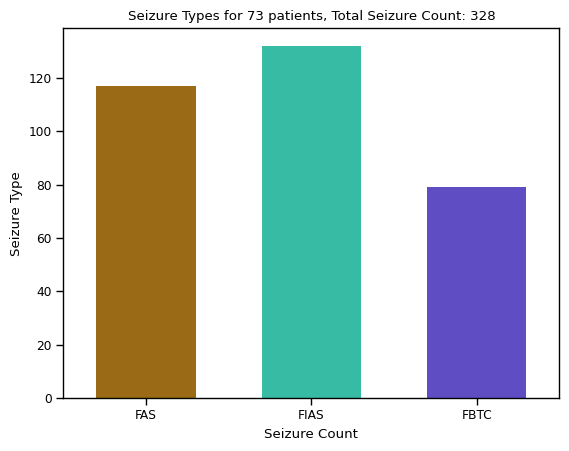

In [10]:
# use non-verbose pipeline
count_df = agg_df[(agg_df.win_sz_st_end == 0) & (agg_df.src_trgt == 'nz_nz')]
count_df = count_df[['eventID','patID','sz_type']].groupby(['sz_type']).count().reset_index()
count_df = count_df[count_df.sz_type.isin(['FAS','FIAS','FBTC'])]
n_patients = agg_df.patID.unique().size

## use verbose pipeline
# count_df = grp_stats_df[['eventID','patID','sz_type']].groupby(['sz_type']).count().reset_index()
# count_df = count_df[count_df.sz_type.isin(['FAS','FIAS','FBTC'])]
# n_patients = grp_stats_df.patID.unique().size

total_sz = count_df.eventID.sum()
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        ax = sns.barplot(
            count_df, 
            x='sz_type',
            y='eventID', 
            hue="sz_type",
            order=['FAS','FIAS','FBTC'],
            width=0.6,
            palette=COLOR_MAP
        )

        plt.title(f"Seizure Types for {n_patients} patients, Total Seizure Count: {total_sz}")

        plt.xlabel("Seizure Count")
        plt.ylabel("Seizure Type")
        # plt.savefig("../viz/sz_counts.pdf", format='pdf', transparent=True)

## Create flow plots grouped by seizure type

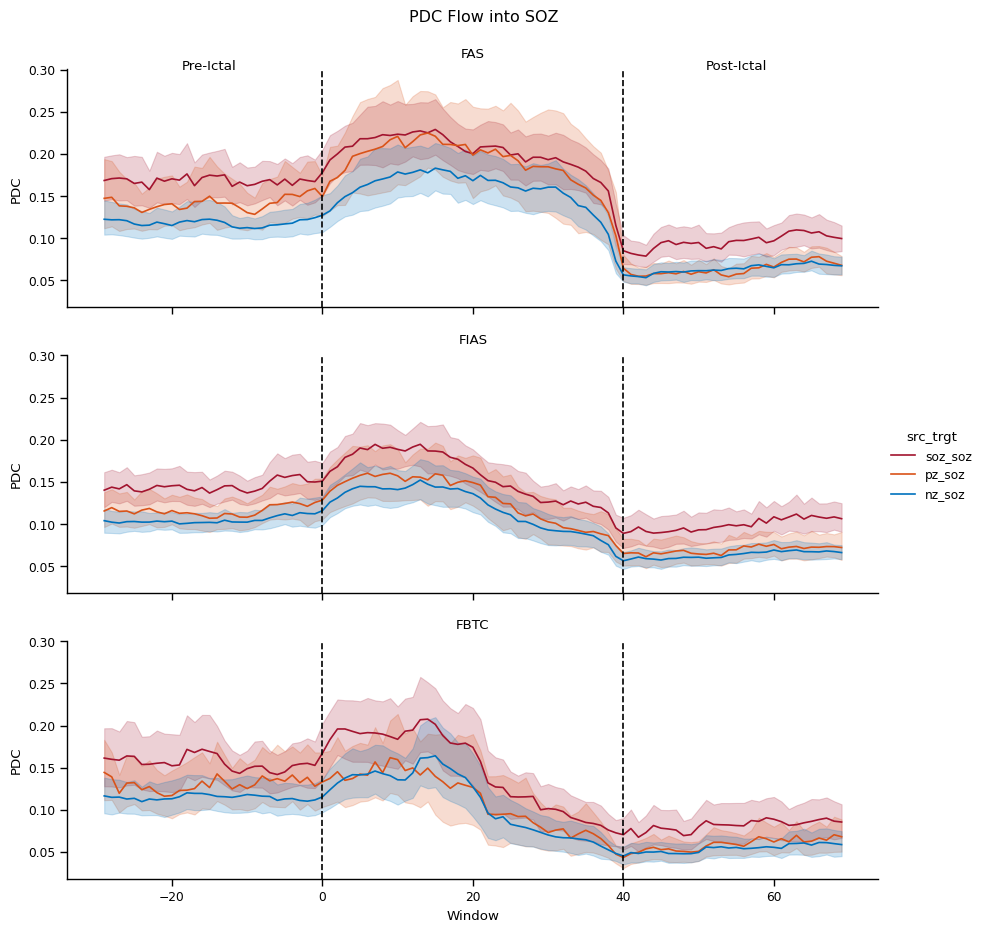

In [109]:
sz_len = 40
xmin = -30
xmax = sz_len + 30
with sns.plotting_context("paper", font_scale=1):
    plot_df = grp_flow_df.copy() # [flow_df.patID == 'Epat03']
    plot_df = plot_df[plot_df.win_sz_st_end > xmin]
    plot_df = plot_df[plot_df.win_sz_st_end < xmax]

    g = sns.relplot(
        data=plot_df, 
        row='sz_type',
        row_order=['FAS','FIAS','FBTC'],
        y='value',
        x='win_sz_st_end',
        hue='src_trgt',
        hue_order=['soz_soz','pz_soz','nz_soz'], ## modify based on target/source of interest
        height=3,
        aspect=3,
        kind='line',
        palette=COLOR_MAP
    )
    
    for ax, sz_type in zip(g.axes.flatten(), ['FAS','FIAS','FBTC']):
        for i in (0,sz_len):
            ax.axvline(i,ls='--',c='k')
        ax.set_ylabel('PDC')
        ax.set_title(sz_type, y=1.015)
    
    g.axes[0][0].text(x=xmin//2, y=0.3, ha='center', s='Pre-Ictal')
    g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.3, ha='center', s='Post-Ictal')
    g.axes[-1][0].set_xlabel('Window')
    g.figure.suptitle("PDC Flow into SOZ",y=1.03)
    plt.subplots_adjust(hspace=0.2)
    
    ## modify file name based on target/source of interest
    plt.savefig("../viz/peri_flow_pdc_noNorm_target_soz_sztypes.pdf", format='pdf', transparent=True)


## Create plot of flow into soz residuals

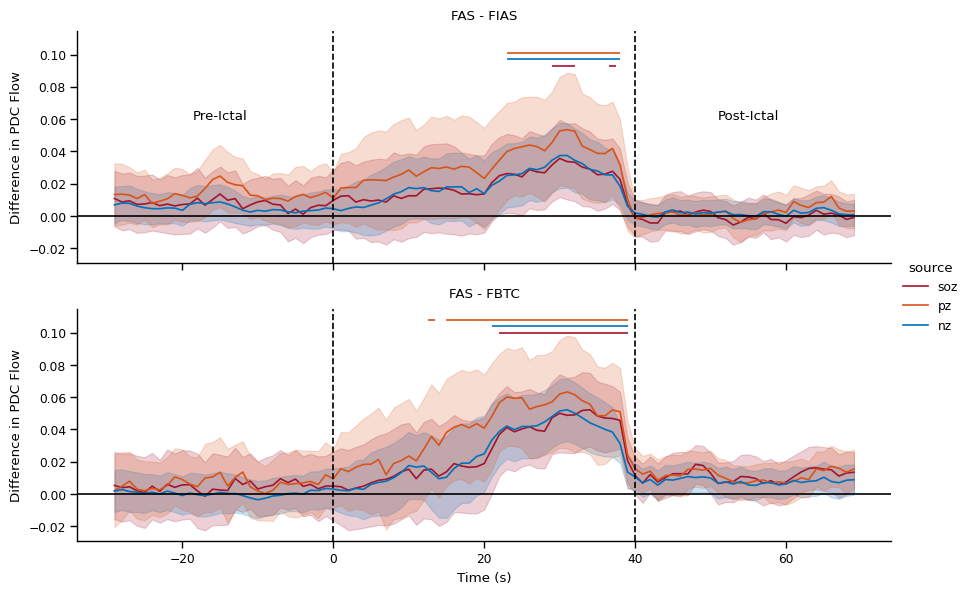

In [9]:
sz_len = 40
xmin = -30
xmax = sz_len + 30
with sns.plotting_context("paper", font_scale=1):
    plot_df = residual_df.copy() # [flow_df.patID == 'Epat03']
    plot_df = plot_df[plot_df.win_sz_st_end > xmin]
    plot_df = plot_df[plot_df.win_sz_st_end < xmax]

    g = sns.relplot(
        data=plot_df, 
        row='sz_type',
        row_order=['FIAS','FBTC'],
        y='value',
        x='win_sz_st_end',
        hue='source',
        hue_order=['soz','pz','nz'],
        height=3,
        aspect=3,
        kind='line',
        palette=COLOR_MAP
    )
    
    for ax, sz_type, yvals in zip(g.axes.flatten(), ['FIAS','FBTC'],[(0.093,0.097,0.101),(0.100,0.104,0.108)]):
        for i in (0,sz_len):
            ax.axvline(i,ls='--',c='k')
        ax.axhline(0,ls='-',c='k')
        ax.set_ylabel(f'Difference in PDC Flow')
        ax.set_title(f'FAS - {sz_type}', y=1.015)
        
        sz_type_df = plot_df[plot_df.sz_type == sz_type]
        for source, yval in zip(['soz','nz','pz'],yvals):
            ax.fill_between(
                x=sz_type_df.loc[sz_type_df.source == source, 'win_sz_st_end'],
                y1=sz_type_df.loc[sz_type_df.source == source, 'ci_lower'],
                y2=sz_type_df.loc[sz_type_df.source == source, 'ci_upper'],
                alpha=0.2,
                color=COLOR_MAP[source]
            )

            # plot significance bars
            ax.hlines(
                y=[yval]*len(plot_sig_windows[sz_type][source]['xmins']),
                xmin=plot_sig_windows[sz_type][source]['xmins'],
                xmax=plot_sig_windows[sz_type][source]['xmaxs'],
                colors=COLOR_MAP[source]
            )
    
    g.axes[0][0].text(x=xmin//2, y=0.06, ha='center', s='Pre-Ictal')
    g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.06, ha='center', s='Post-Ictal')
    g.axes[-1][0].set_xlabel('Time (s)')
    plt.subplots_adjust(hspace=0.2)
    
    # modify file name based on target/source of interest
    plt.savefig("../viz/peri_flow_pdc_noNorm_target_soz_residuals_sztypes.pdf", bbox_inches='tight', format='pdf', transparent=True)
    plt.savefig("../viz/peri_flow_pdc_noNorm_target_soz_residuals_sztypes.svg", bbox_inches='tight',format='svg')


In [150]:
plot_df

,sz_type,source,win_sz_st_end,value,ci_lower,ci_upper
6,FIAS,soz,-29,0.010737,-0.006449,0.027923
7,FBTC,soz,-29,0.005241,-0.015601,0.026083
8,FIAS,pz,-29,0.013164,-0.006233,0.032562
9,FBTC,pz,-29,0.002023,-0.020667,0.024713
10,FIAS,nz,-29,0.006768,-0.004501,0.018038
...,...,...,...,...,...,...
421,FBTC,soz,40,0.011421,-0.000139,0.022981
422,FIAS,pz,40,-0.001809,-0.013401,0.009782
423,FBTC,pz,40,0.015631,0.003026,0.028237
424,FIAS,nz,40,0.001723,-0.005712,0.009158


## Create flow plots by sz type with FPAC vs. non-FPAC

In [ ]:
sz_len = 40
xmin = -30
xmax = sz_len + 30
with sns.plotting_context("paper", font_scale=1):
    plot_df = grp_flow_fpac_df.copy() # [grp_flow_df.FPAC == 0]
    plot_df = plot_df[plot_df.win_sz_st_end > xmin]
    plot_df = plot_df[plot_df.win_sz_st_end < xmax]

    g = sns.relplot(
        data=plot_df, 
        row='sz_type',
        row_order=['FAS','FIAS','FBTC'],
        y='value',
        x='win_sz_st_end',
        hue='src_trgt',
        hue_order=['soz_soz','pz_soz','nz_soz'],
        height=3,
        aspect=3,
        kind='line',
        palette=COLOR_MAP
    )
    
    for ax, sz_type in zip(g.axes.flatten(), ['FAS','FIAS','FBTC']):
        for i in (0,sz_len):
            ax.axvline(i,ls='--',c='k')
        ax.set_ylabel('PDC')
        ax.set_title(sz_type, y = 1.015)
    
    g.axes[0][0].text(x=xmin//2, y=0.2, ha='center', s='Pre-Ictal')
    g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.2, ha='center', s='Post-Ictal')
    g.axes[-1][0].set_xlabel('Window')
    g.figure.suptitle("Peri-Ictal PDC Flow",y=1.03)
    
    plt.savefig("../viz/peri_flow_pdc_noNorm_target_soz.pdf", format='pdf', transparent=True)


## Create individual broken axes plots

In [23]:
# sz_len = 40
# xmin = -60
# xmax = sz_len + 60
# bax = brokenaxes(xlims=((-400,-350), (xmin,xmax),(350,400)))
# sz_type='FAS'
# with sns.plotting_context("paper", font_scale=1.5):
#     plot_df = grp_flow_df # [flow_df.patID == 'Epat03']
#     # plot_df = plot_df[plot_df.win_sz_st_end > xmin]
#     # plot_df = plot_df[plot_df.win_sz_st_end < xmax]

#     for ax in bax.axs:
#         g = sns.lineplot(
#             data=plot_df[plot_df.sz_type == sz_type],
#             y='value',
#             x='win_sz_st_end',
#             hue='src_trgt',
#             hue_order=['nz_soz','nz_pz','nz_nz'],
#             palette=COLOR_MAP,
#             ax=ax
#         )
    
#     # for ax, sz_type in zip(g.axes.flatten(), ['FAS','FIAS','FBTC']):
#     #     for i in (0,sz_len):
#     #         ax.axvline(i,ls='--',c='k')
#     #         ax.set_ylabel('Net PDC')
#     #         ax.set_title(sz_type)
    
#     bax.axs[0].text(x=xmin//2, y=0.2, s='Pre-Ictal')
#     g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.2, s='Post-Ictal')
#     g.axes[-1][0].set_xlabel('Window')
#     g.figure.suptitle(f"Peri-Ictal PDC Flow, {sz_type}",y=1.03)
    
#     plt.savefig(f"../viz/peri_flow_pdc_noNorm_nz_{sz_type}.pdf", format='pdf', transparent=True)
